In [10]:
## Jax-based CNN for image classification.
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.scipy.special import logsumexp
from jax.example_libraries import stax, optimizers
from jax.example_libraries.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax)
import torch
from torchvision import datasets, transforms
import time

# Key to use for randomization
key = random.PRNGKey(1)

In [11]:
# Constants
BATCH_SIZE_ = 100
IMG_SIDE_SIZE_ = 28
NUM_CLASSES_ = 10
STEP_SIZE_ = 1e-3

In [21]:
# Plotting Functions
import matplotlib.pyplot as plt
import seaborn as sns

def plot_examples(data_loader, num_examples=5):
    images = []
    targets = []
    for data, target in data_loader:
        images.extend(jnp.array(data).reshape(data.size(0), IMG_SIDE_SIZE_, IMG_SIDE_SIZE_))
        targets.extend(jnp.array(target))
    fig, axs = plt.subplots(1, num_examples, figsize=(10, 5))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(images[i], cmap="Greys")
        ax.set_title("Label: {}".format(targets[i]), fontsize=25)
        ax.set_axis_off()
    fig.tight_layout()

def plot_win_and_loss_examples(model, final_params, data_loader, num_examples):
    images_for_viz = []
    actual = []
    preds = []
    for data, target in data_loader:
        images = jnp.array(data)
        predictions = jnp.argmax(model(final_params, images), axis=1)
        # Reshape image vector for figure viz.
        images_for_viz.extend(images.reshape(data.size(0), IMG_SIDE_SIZE_, IMG_SIDE_SIZE_))
        actual.extend(target)
        preds.extend(predictions)

    # Convert all to jnp arrays to allow masking.
    images_for_viz = jnp.array(images_for_viz)
    actual = jnp.array(actual)
    preds = jnp.array(preds)


    # Correct Predictions
    correct_predictions = actual == preds
    for color, mask in (("green", correct_predictions), ("red", ~correct_predictions)):
        imgs_to_show = images_for_viz[mask]
        preds_to_show = preds[mask]
        actual_to_show = actual[mask]  
    
        if min(num_examples, imgs_to_show.shape[0]) == 0:
            raise ValueError("Not Enough Examples for Part.")
        fig, axs = plt.subplots(1, min(num_examples, imgs_to_show.shape[0]), figsize=(10, 5))    
        for i, ax in enumerate(axs.flatten()):
            ax.imshow(imgs_to_show[i], cmap="Greys")
            ax.set_title("Pred: {}, Actual: {}".format(preds_to_show[i], actual_to_show[i]), fontsize=15, color=color)
            ax.set_axis_off()
        fig.tight_layout()

In [13]:
def getMNISTDatasetLoaders():
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE_, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE_, shuffle=True)
    return train_loader, test_loader

In [14]:
def one_hot(X, k):
    return jnp.array(X[:, None] == jnp.arange(k))

def accuracy(params, data_loader, model):
    total_correct = 0
    for data, target in data_loader:
        images = jnp.array(data)
        targets = one_hot(jnp.array(target), NUM_CLASSES_)
        target_class = jnp.argmax(targets, axis=1)
        predicted_class = jnp.argmax(model(params, images), axis=1)
        total_correct += jnp.sum(predicted_class == target_class)
    return total_correct/len(data_loader.dataset)

def loss(params, images, targets, model):
    # Targets are a one-hot encoding.
    predictions = model(params, images)
    return -jnp.sum(predictions*targets)

@jit
def update(params, x, y, opt_state):
    # Uses gradient to update parameters.
    value, grads = value_and_grad(loss)(params,x,y, CNN)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

def print_training_state(params, train_loader, test_loader, epoch=0, time_taken=0):
    print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch,
                                                            time_taken,
                                                            accuracy(params,train_loader, CNN),
                                                            accuracy(params,test_loader, CNN)))

In [15]:
def plot_training_losses(training_losses):
    plt.plot(training_losses)
    plt.xlabel("# Batch Updates")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

def train_model(initial_opt_state, num_epochs):
    training_losses = []
    opt_state = initial_opt_state
    params = get_params(initial_opt_state)
    print_training_state(params, train_loader, test_loader, 0, 0)

    for epoch in range(1, num_epochs+1):
        start_ts = time.time()
        for data, target in train_loader:
            X = jnp.array(data)
            Y = one_hot(jnp.array(target), NUM_CLASSES_)
            params, opt_state, loss_val = update(params, X, Y, opt_state)
            training_losses.append(loss_val)
        print_training_state(params, train_loader, test_loader, epoch, time.time() - start_ts)

    return training_losses, params

In [16]:
init_fn, CNN = stax.serial(Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"), 
                                 Relu,
                                 Flatten,
                                 Dense(NUM_CLASSES_),
                                 LogSoftmax)
_, initial_params = init_fn(key, (BATCH_SIZE_, 1, IMG_SIDE_SIZE_, IMG_SIDE_SIZE_))

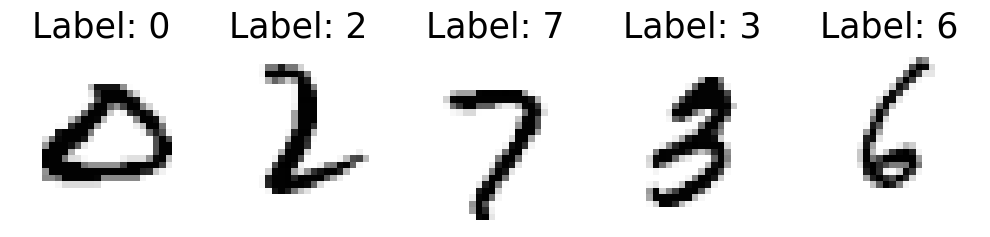

In [17]:
# Retrieve Data
train_loader, test_loader = getMNISTDatasetLoaders()
plot_examples(train_loader, num_examples=5)

In [18]:
opt_init, opt_update, get_params = optimizers.adam(STEP_SIZE_)
initial_opt_state = opt_init(initial_params)
training_losses, final_params = train_model(initial_opt_state, num_epochs=12)

Epoch 0 | T: 0.00 | Train A: 0.081 | Test A: 0.079
Epoch 1 | T: 5.01 | Train A: 0.969 | Test A: 0.968
Epoch 2 | T: 4.60 | Train A: 0.978 | Test A: 0.974
Epoch 3 | T: 4.58 | Train A: 0.982 | Test A: 0.978
Epoch 4 | T: 4.60 | Train A: 0.986 | Test A: 0.979
Epoch 5 | T: 4.60 | Train A: 0.987 | Test A: 0.981
Epoch 6 | T: 4.57 | Train A: 0.989 | Test A: 0.982
Epoch 7 | T: 4.56 | Train A: 0.990 | Test A: 0.981
Epoch 8 | T: 4.58 | Train A: 0.991 | Test A: 0.983
Epoch 9 | T: 4.57 | Train A: 0.992 | Test A: 0.983
Epoch 10 | T: 4.62 | Train A: 0.993 | Test A: 0.983
Epoch 11 | T: 4.63 | Train A: 0.994 | Test A: 0.983
Epoch 12 | T: 4.58 | Train A: 0.994 | Test A: 0.984


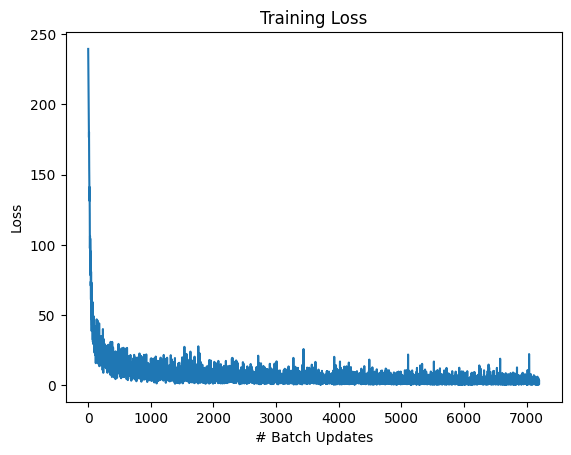

In [19]:
plot_training_losses(training_losses)

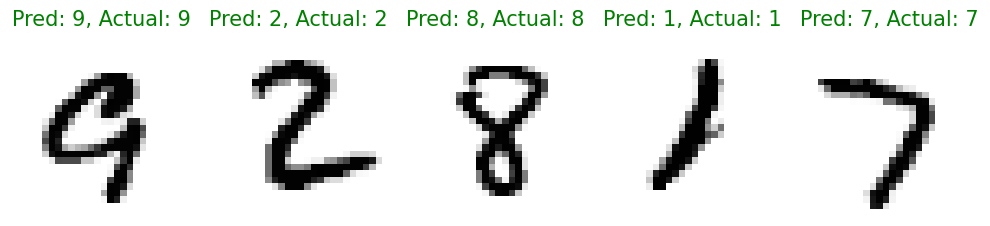

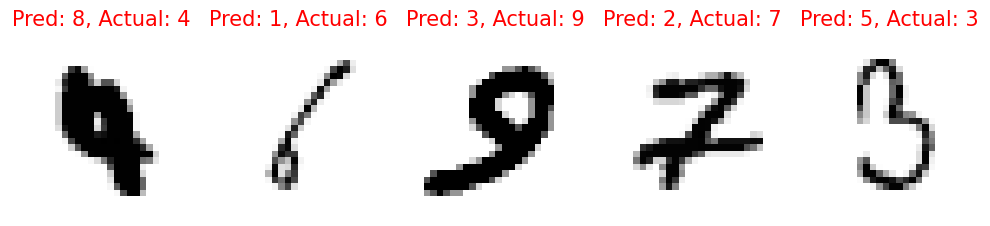

In [22]:
plot_win_and_loss_examples(CNN, final_params, test_loader, num_examples=5)